In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
#### Preprocecing ###

In [3]:
jh_dir = "../../COVID-19"

In [4]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [8]:
### Data Preparation ###

In [9]:
country = 'Japan'
epoch = pd.to_datetime('2020-02-01')
last = pd.to_datetime('2020-04-19')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [10]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [11]:
### Model ###

In [44]:
sm_1 = pystan.StanModel(file="single-step.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_64e3e20c609dd612f47cd7ecbb535ab6 NOW.


In [42]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e567988d191d71932d1a0a66905e35b0 NOW.


In [45]:
# Train the model and generate samples
fit_1 = sm_1.sampling(data=data, iter=iteration, init='random', control={'adapt_delta':0.99999})
fit_1


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_64e3e20c609dd612f47cd7ecbb535ab6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   40.3   32.06  45.39   0.39   2.73  23.31  78.69 118.84      2  57.77
b0         1.35    0.87   1.24   0.07   0.16   1.13    2.6   3.03      2 258.81
b1         0.84    0.82   1.16   0.06   0.11   0.23   1.65   2.92      2 101.06
theta_b    2.48    1.57   2.21   0.35    0.7   1.74   4.41   6.12      2  649.6
b_date    32.96   13.16  18.62    6.1   17.7  33.47  48.24  58.65      2 809.76
p          0.41    0.22   0.31   0.03    0.1   0.44   0.71   0.73      2 1351.9
q0         0.82    0.06   0.08   0.71   0.74   0.82    0.9   0.92      2  71.33
q1         0.86    0.17   0.24   0.44   0.69   0.99    1.0    1.0      2 6793.5
theta_q     2.0    1.18   1.67   0.14   0.44   1.71

In [ ]:
# Train the model and generate samples
fit_const = sm_const.sampling(data=data, iter=iteration, init='random')
fit_const

In [ ]:
# Save models

In [ ]:
## Saving results

In [ ]:
import pickle
with open("sm1_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_1, 'fit' : fit_1}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

In [ ]:
import pickle
with open("sm_const_fit.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

In [ ]:
### Load modesl

In [ ]:
with open("sm1_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_1 = data_dict['model']
fit_start_1 = data_dict['fit']
# fit = data_list[1]

In [ ]:
# with open("sm2_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# sm_2 = data_dict['model']
# fit_start_2 = data_dict['fit']
# # fit = data_list[1]

In [ ]:
with open("sm_const_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [ ]:
### Convergence

In [33]:
#data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_1 = az.from_pystan(fit_1, log_likelihood='log_lik')

In [ ]:
az.plot_trace(data_const, var_names=['init_inf', 'b', 'p', 'a', 'd', 'q'])

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8be1e9cd50>,
      dtype=object)

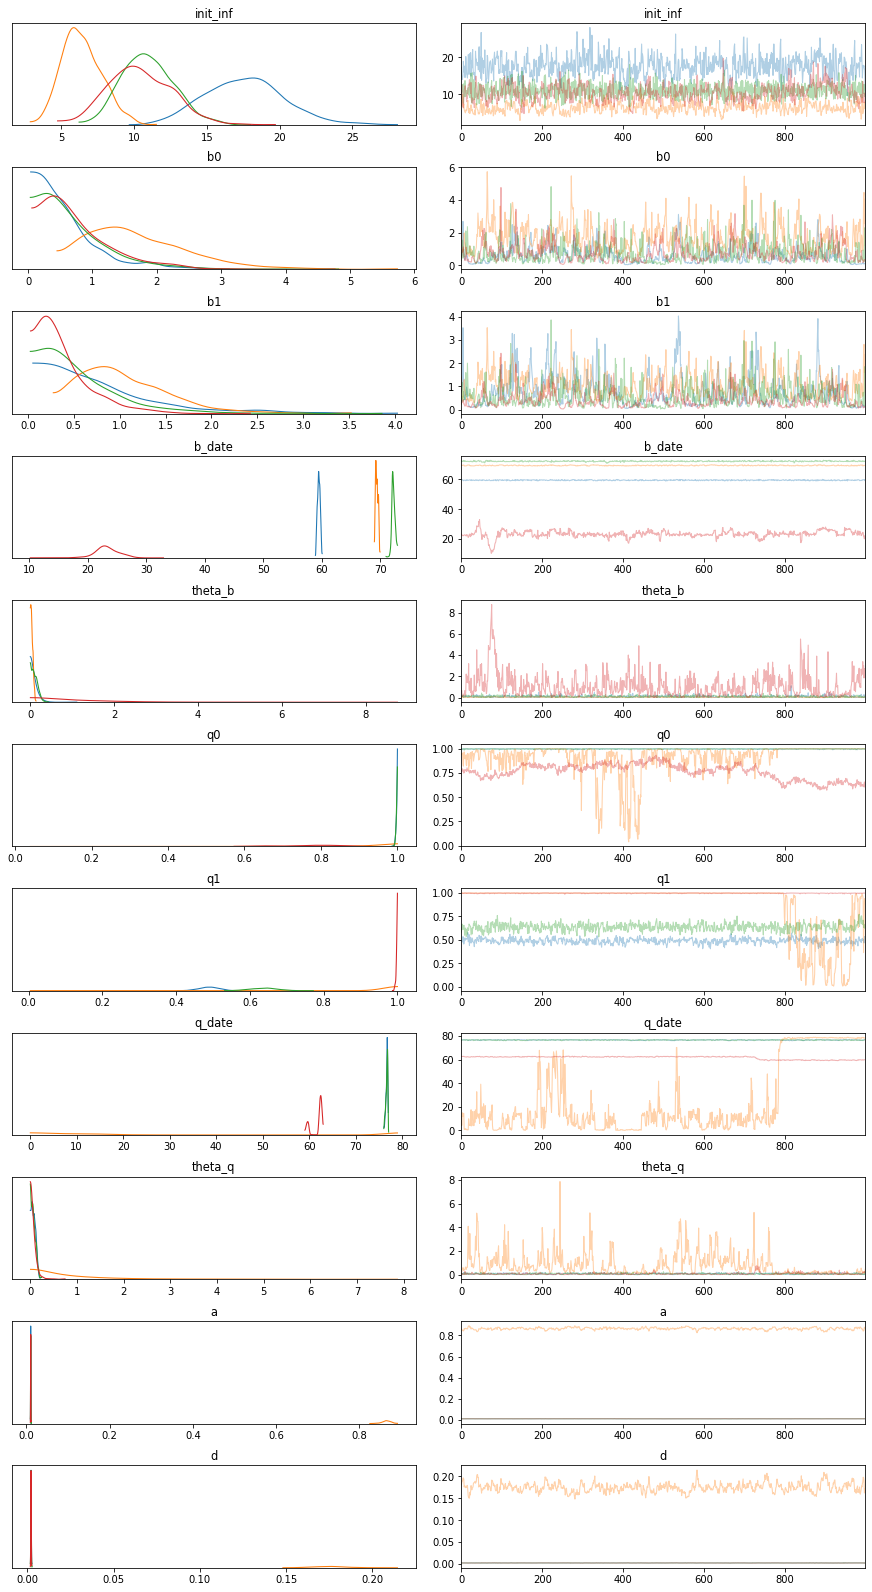

In [34]:
az.plot_trace(data_1, var_names=['init_inf', 'b0', 'b1', 'b_date', 'theta_b', 'q0', 'q1', 'q_date', 'theta_q', 'a', 'd'], divergences='top')

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/pairplot.py:90: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 9x9 grid
  SyntaxWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c12194c50>,
      dtype=object)

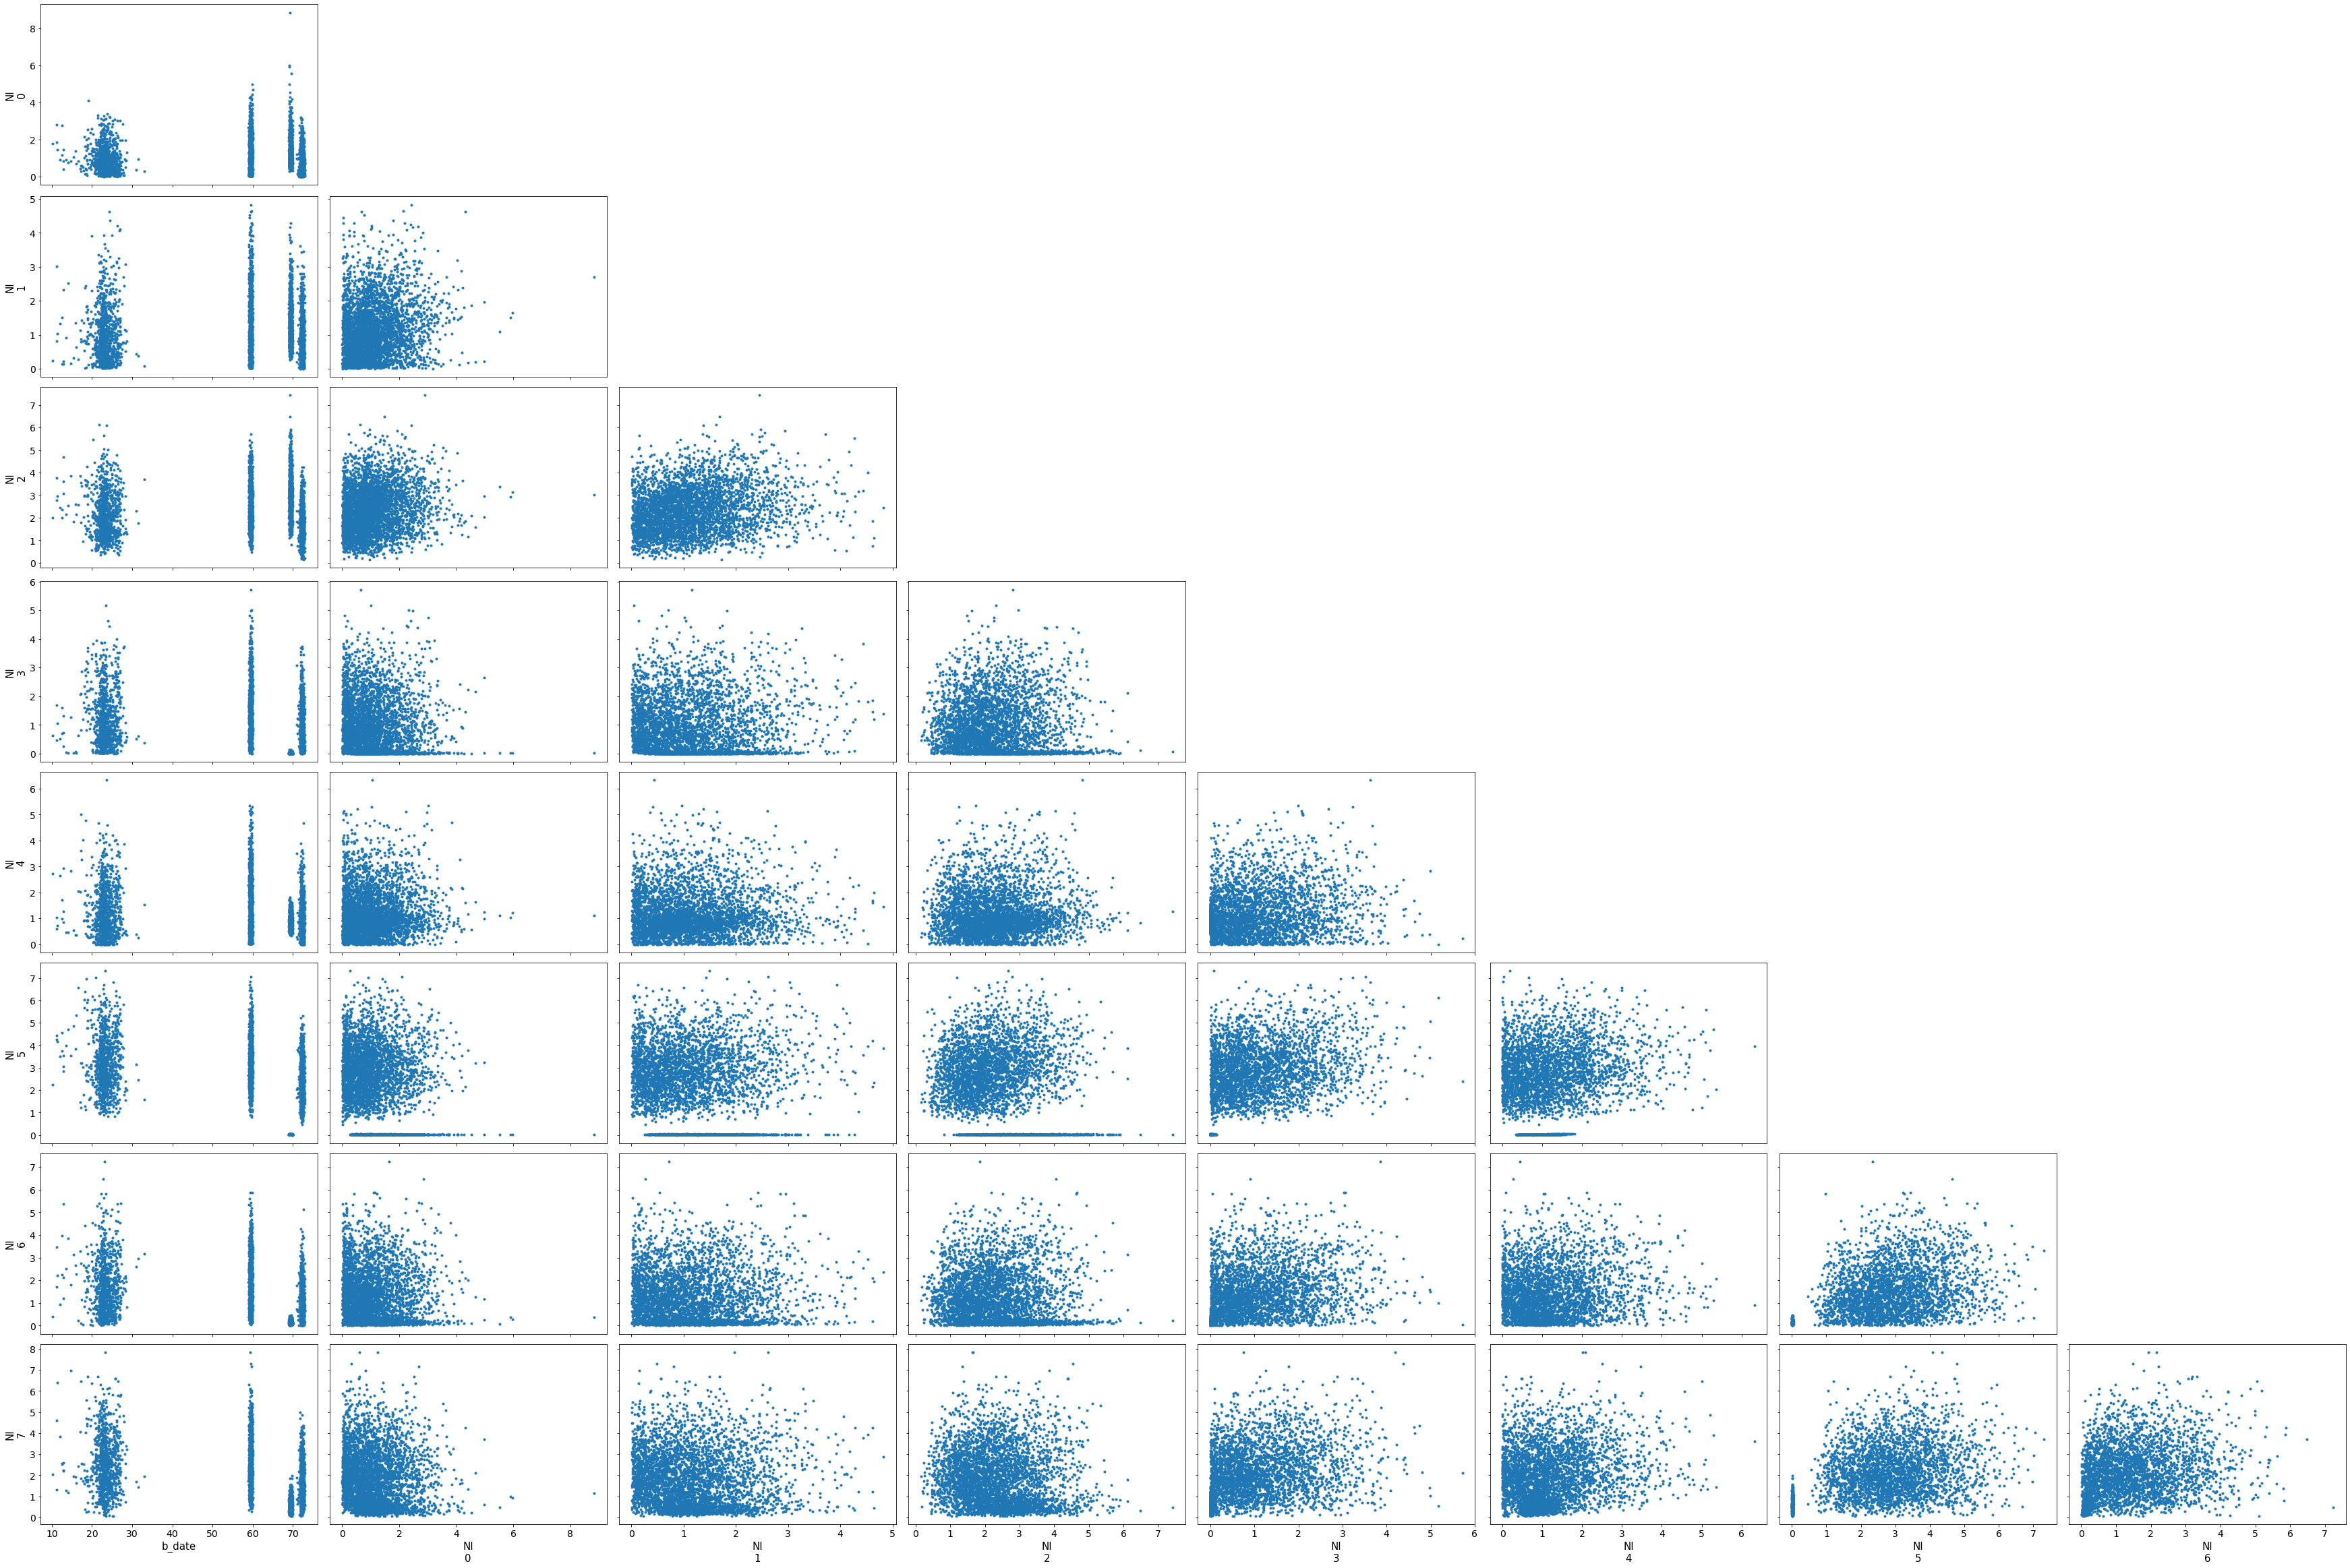

In [41]:
az.plot_pair(data_1, var_names=['b_date', 'NI'])

In [ ]:
data_1

In [ ]:
## Validation by simulation

In [ ]:
def sigmoid(x, theta, t0):
    return 1/(1 + np.exp(-(x-t0)/theta))

In [ ]:
def simulate(init_inf, b0, b1, theta_b, b_date, q0, q1, theta_q, q_date,
             a, d, p, horizon):
    C = init_inf;
    R = 0;
    D = 0;
    C_list = [C]
    R_list = [R]
    D_list = [D]
    b_list = [b0]
    q = q0 + (q1 - q0) * sigmoid(0, theta_q, q_date)
    q_list = [q]
    C0 = [scipy.stats.poisson.rvs(q*init_inf)]
    R0 = [scipy.stats.poisson.rvs(a * C0[0])]
    D0 = [scipy.stats.poisson.rvs(d * C0[0])]
    for t in range(horizon):
        b = b0 + (b1-b0) * sigmoid(t, theta_b, b_date)
        NI = (1 - pow(1 - p, b * (C - R - D) / (P - D))) * (P - C)
#        NI = (C - R - D) * b * p * (1 - C/P)
        q = q0 + (q1 - q0) * sigmoid(t, theta_q, q_date)
        NR = a * (C - R - D)
        ND = d * (C - R - D)
        D = D + ND
        C = C + NI
        R = R + NR
        C_list.append(C)
        R_list.append(R)
        D_list.append(D)
        b_list.append(b)
        q_list.append(q)
        NI0 = scipy.stats.poisson.rvs(q*NI)
        NR0 = scipy.stats.poisson.rvs(a * (C0[-1] - R0[-1] - D0[-1]))
        ND0 = scipy.stats.poisson.rvs(d * (C0[-1] - R0[-1] - D0[-1]))
        C0.append(C0[-1]+NI0)
        R0.append(R0[-1]+NR0)
        D0.append(D0[-1]+ND0)
    data = pd.DataFrame({'C':np.array(C_list),
                        'R':np.array(R_list),
                        'D':np.array(D_list),
                        'b':np.array(b_list),
                        'q':np.array(q_list),
                        'C0':np.array(C0),
                        'R0':np.array(R0),
                        'D0':np.array(D0)},
                        index=pd.date_range(start=epoch, periods=horizon+1, freq='D'))
    return data

In [ ]:
fit_1['NI[77]'].mean() * fit_1['q[77]'].mean()

In [ ]:
(fit_1['b0']*fit_1['p']).mean()

In [ ]:
i = 0
fit = fit_1
horizon=(pd.to_datetime('2020-04-18') - pd.to_datetime('2020-02-01')).days
df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      p=fit['p'][i],
                      horizon=horizon)
df['NI']

In [ ]:
C0S

In [ ]:
C0S = df['C0'].values
R0S = df['R0'].values
D0S = df['D0'].values
data_simulated = {'T': C0S.shape[0], 'T0': 0, 'P': P, 'C0': C0S, 'R0': R0S, 'D0':D0S}

In [ ]:
# Train the model and generate samples
fit_simulated = sm_1.sampling(data=data_simulated, iter=2000, init='random')
fit_simulated

In [ ]:
i = 0
(fit_1['init_inf'][i], fit_1['b0'][i], fit_1['b1'][i], fit_1['theta_b'][i], 
fit_1['b_date'][i], fit_1['p'][i], fit_1['q0'][i], fit_1['q1'][i], fit_1['theta_q'][i], fit_1['q_date'][7]
,fit_1['a'][i], fit_1['d'][i])

In [ ]:
data_sim = az.from_pystan(fit_simulated, log_likelihood='log_lik')

In [ ]:
az.plot_trace(data_sim, var_names=['b1', 'b_date', 'p'])

In [ ]:
### Visualization ###

In [ ]:
def monte_carlo(fit, horizon):
    S = pd.DataFrame()
    R = pd.DataFrame()
    D = pd.DataFrame()
    b = pd.DataFrame()
    q = pd.DataFrame()
    S0 = pd.DataFrame()
    R0 = pd.DataFrame()
    I0 = pd.DataFrame()
    D0 = pd.DataFrame()
    n = fit['init_inf'].shape[0]
    for k in range(repeat):
        
        df = simulate(init_inf=fit['init_inf'][i],
                      b0=fit['b0'][i],
                      b1=fit['b1'][i],
                      theta_b=fit['theta_b'][i],
                      b_date=fit['b_date'][i],
                      q0=fit['q0'][i],
                      q1=fit['q1'][i],
                      theta_q=fit['theta_q'][i],
                      q_date=fit['q_date'][i],
                      a=fit['a'][i],
                      d=fit['d'][i],
                      p=fit['p'][i],
                      horizon=horizon)
        C = pd.concat([S, df['C']], axis=1)
        R = pd.concat([R, df['R']], axis=1)
        D = pd.concat([D, df['D']], axis=1)
        b = pd.concat([b, df['b']], axis=1)
        q = pd.concat([q, df['q']], axis=1)
        C0 = pd.concat([S0, df['C0']], axis=1)
        R0 = pd.concat([R0, df['R0']], axis=1)
        D0 = pd.concat([D0, df['D0']], axis=1)
        I0 = pd.concat([I0, df['C0'] - df['R0'] - df['D0']], axis=1)
    return C, R, D, b, q, C0, R0, I0, D0
    

In [ ]:
def extract_series(fit, name):
    value_list = []
    for d in range(78):
        vals = fit['{}[{}]'.format(name, d+1)]
        value_list.append(vals)
    data = np.array(value_list)
    return pd.DataFrame(data, 
                        index=pd.date_range(start=epoch, periods=78, freq='D'))

In [ ]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-18')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [ ]:
C, R, D, b, q, C0S, R0S, I0S, D0S = monte_carlo(fit_1, 120)

In [ ]:
NI= extract_series(fit_1, 'NI')

In [ ]:
draw(NI.cumsum(), real=(confirmed-recovered)[country])

In [ ]:
S.median(axis=1)[pd.to_datetime('2020-04-18')]

In [ ]:
draw(q)

In [ ]:
draw(b)

In [ ]:
draw(R0S, real=recovered[country])

In [ ]:
draw(D0S, real=death[country])

In [ ]:
draw(S, upto=pd.to_datetime('2020-05-30'))

In [ ]:
draw(D, upto=pd.to_datetime('2020-05-30'))

In [ ]:
### model selection

In [ ]:
az.loo(data_const)

In [ ]:
az.loo(data_1)

In [ ]:
az.compare({'const':data_const, '1-step':data_1})

In [ ]:
az.loo(data_1, pointwise=True)

In [ ]:
az.loo(data_const, pointwise=True)

In [ ]:
data_CV = {'T': C0.shape[0], 'T0': 50, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [ ]:
# Train the model and generate samples
fit_1_CV = sm_1.sampling(data=data_CV, iter=iteration, init=0)


In [ ]:
v_log_lik = fit_1_CV['v_log_lik']
v_log_lik[~np.isnan(v_log_lik)].mean()

In [ ]:
# Train the model and generate samples
fit_const_CV = sm_const.sampling(data=data_CV, iter=iteration, init=0)
fit_const_CV['v_log_lik'].mean()

In [ ]:
fit_1_CV

In [ ]:
fit_const_CV

In [60]:
from scipy.stats import norm
def poisson_approx_cum(k, rate):
    c = pow(rate/(1+k), 1/3)
    mu = 1- 1/(9*k+9)
    sigma = 1/(3*np.sqrt(1+k))
    return norm.logcdf(c-mu, sigma)


In [65]:
poisson_approx_cum(10, 1)

-1.3438488020694246

In [67]:
norm.logcdf(2, 1)

-0.1727537790234499